### Assignment 4 - Digital Twin in Action 
#### Task 2
###### Group 5

In [1]:
import sqlite3
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np



We first briefly open and verify the content of database using DB Browser for SQLite. We can already see that it has one table with 3 columns: Timestamp, Zone, and Value. Now let's read the database and display the contents of the table in this notebook.

In [2]:
conn = sqlite3.connect("Monitoring.db")
df = pd.read_sql("SELECT * FROM RuntimeData;", conn)
df.head()

,Timestamp,Zone,Value
0,01.01.2023 01:00,Zone1,22.034781
1,01.01.2023 02:00,Zone1,21.983360
2,01.01.2023 03:00,Zone1,21.895082
3,01.01.2023 04:00,Zone1,21.777768
4,01.01.2023 05:00,Zone1,21.637705


In [3]:
df.describe()
df["Zone"].unique()


array(['Zone1', 'Zone2', 'Zone3', 'Zone4'], dtype=object)

We can see. there is 4 different zones in the data and from the assignment description we know that they correspond to different rooms in the building: basement, a stairwell, an office area and a living area.

To understand the distribution of the sensor values, we plot a histogram of all the values in the database.

From the range, we can see that the sensor values are likely temperature readings in Celsius, as they fall within a reasonable range for indoor temperatures. Other alternatives, such as humidity or CO2 levels, would typically have different value ranges.


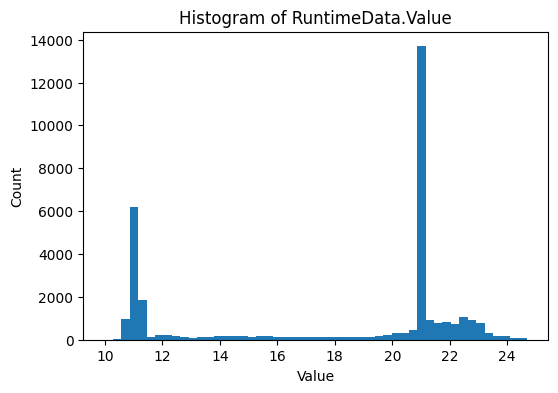

In [4]:
values = pd.to_numeric(df["Value"], errors="coerce").dropna().to_numpy(dtype=float)
values = values[np.isfinite(values)]  

edges = np.linspace(values.min(), values.max(), 51)
counts, _ = np.histogram(values, bins=edges)

centers = 0.5 * (edges[:-1] + edges[1:])
widths  = edges[1:] - edges[:-1]

plt.figure(figsize=(6,4))
plt.bar(centers, counts, width=widths)
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of RuntimeData.Value")
plt.show()


Now, we will analyze the temperature data for each zone separately. We will create histograms for each zone to see how the temperature distributions differ across the different areas of the building.

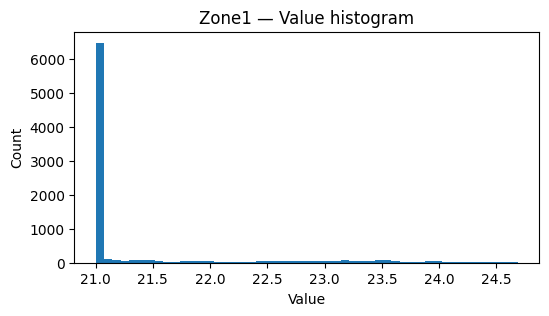

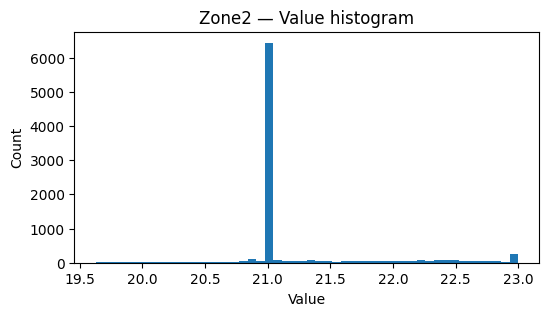

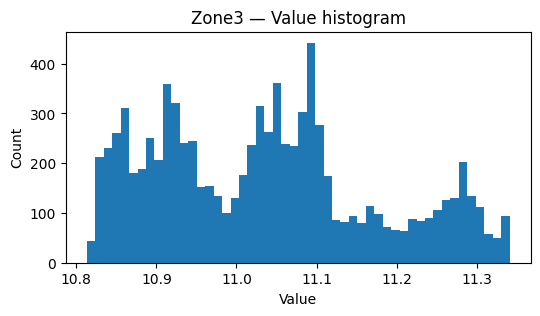

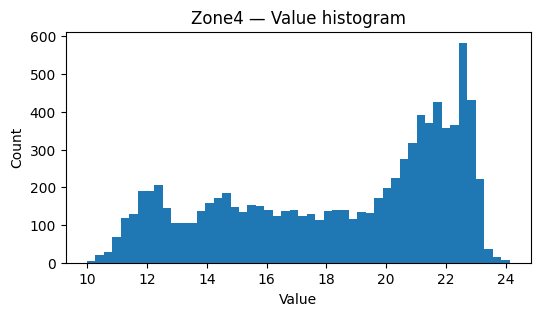

In [5]:
for z in df["Zone"].unique():
    v = pd.to_numeric(df.loc[df["Zone"] == z, "Value"], errors="coerce").dropna().to_numpy(dtype=float)
    v = v[np.isfinite(v)]
    if len(v) < 2:
        continue

    edges = np.linspace(v.min(), v.max(), 51)
    counts, _ = np.histogram(v, bins=edges)
    centers = 0.5 * (edges[:-1] + edges[1:])
    widths  = edges[1:] - edges[:-1]

    plt.figure(figsize=(6,3))
    plt.bar(centers, counts, width=widths)
    plt.title(f"{z} — Value histogram")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()


From the histograms, we can observe the following:
- Zone 1 and Zone 2 have both the majority of their temperature readings concentrated around 20-22 degrees Celsius, indicating that these areas are likely maintained at a comfortable room temperature, with the heating system being on at most of the hours in a day.
- Zone 3 shows a wider spread of temperature values, with a significant number of readings below 12 degrees Celsius. This suggests that this area may not be as well insulated or heated as the other zones, possibly indicating a less frequently used area or one that is more exposed to external temperature variations with no aim of providing a comfortable temperature for the occupants.
- Zone 4 has a distribution that indicates the range of the temparutes spreads the whole spectrum from 10 to 24 degrees Celsius, with a peak around 23 degrees. This could suggest that this area experiences more significant temperature fluctuations, possibly due to its location within the building or its usage patterns.

Belowe we provide the code used for the statistical analysis.

In [6]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], dayfirst=True, errors="coerce")
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna(subset=["Timestamp","Zone","Value"]).sort_values("Timestamp")

stats = df.groupby("Zone")["Value"].agg(["count","min","median","max","std"])
stats


,count,min,median,max,std
Zone,,,,,
Zone1,8759,21.000000,21.000000,24.690487,0.884301
Zone2,8759,19.627511,21.000000,23.000000,0.563355
Zone3,8759,10.813095,11.032599,11.341009,0.137852
Zone4,8759,9.977620,19.642930,24.131874,3.801324


We now confirm the data was collected over a full year by checking the timestamp range.

In [7]:
print("Rows:", len(df))
print("Zones:", df["Zone"].nunique())
print("Zone names:", sorted(df["Zone"].unique()))
print("Time span:", df["Timestamp"].min(), "to", df["Timestamp"].max())


Rows: 35036
Zones: 4
Zone names: ['Zone1', 'Zone2', 'Zone3', 'Zone4']
Time span: 2023-01-01 01:00:00 to 2023-12-31 23:00:00


Now, we look for gaps being missing data in the time series for each zone and next we check if any duplicate timestamps exist within each zone.

In [8]:
wide = df.pivot(index="Timestamp", columns="Zone", values="Value").sort_index()

missing_pct = (wide.isna().mean() * 100).round(2).sort_values(ascending=False)
missing_pct


Zone
Zone1    0.0
Zone2    0.0
Zone3    0.0
Zone4    0.0
dtype: float64

In [9]:
dups = df.duplicated(subset=["Timestamp", "Zone"]).sum()
print("Duplicate (Timestamp, Zone) rows:", dups)


Duplicate (Timestamp, Zone) rows: 0


Overal mean behavior of the temperature values across all zones is as follows:

/var/folders/s4/jjydc80j5k72df06dkmdylmr0000gn/T/ipykernel_70767/3711765722.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = wide.resample("1M").mean()


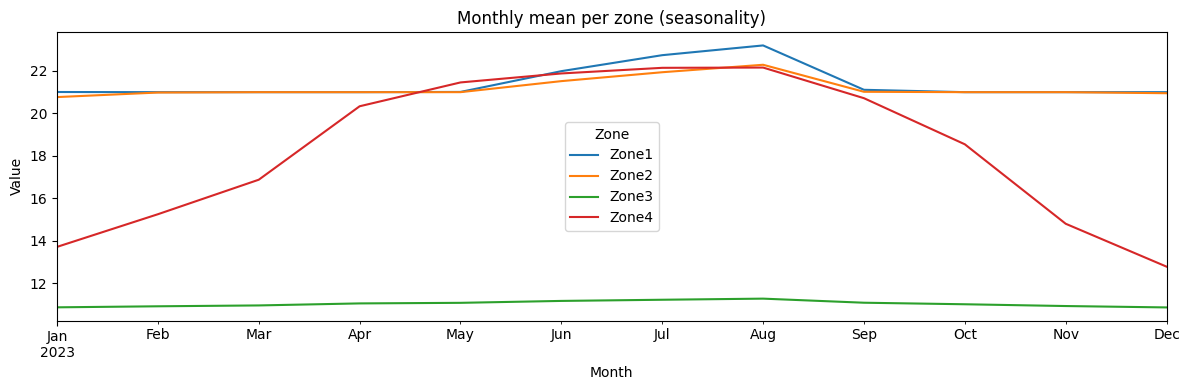

In [ ]:
monthly = wide.resample("1M").mean()
ax = monthly.plot(figsize=(12,4))
ax.set_title("Monthly mean per zone (seasonality)")
ax.set_xlabel("Month")
ax.set_ylabel("Value")
plt.tight_layout()
plt.show()


/var/folders/s4/jjydc80j5k72df06dkmdylmr0000gn/T/ipykernel_70767/3999564134.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = wide.resample("1H").mean()


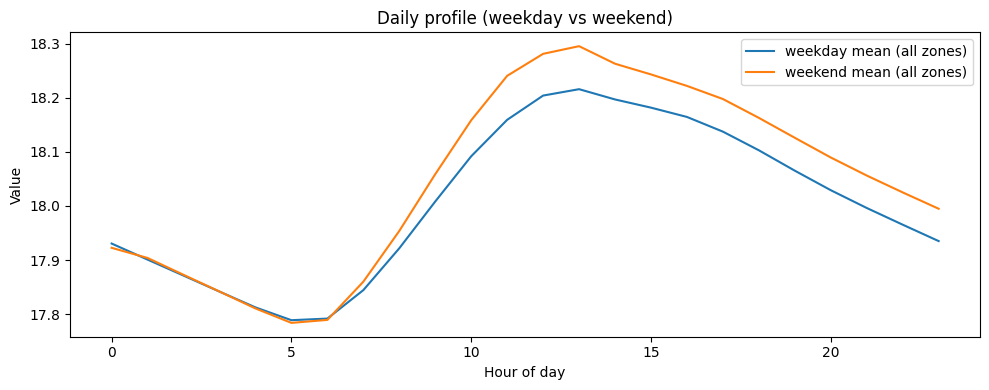

In [11]:
hourly = wide.resample("1H").mean()

wk = hourly[hourly.index.dayofweek < 5].groupby(hourly[hourly.index.dayofweek < 5].index.hour).mean()
we = hourly[hourly.index.dayofweek >= 5].groupby(hourly[hourly.index.dayofweek >= 5].index.hour).mean()

plt.figure(figsize=(10,4))
plt.plot(wk.index, wk.mean(axis=1), label="weekday mean (all zones)")
plt.plot(we.index, we.mean(axis=1), label="weekend mean (all zones)")
plt.title("Daily profile (weekday vs weekend)")
plt.xlabel("Hour of day")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()


In the heatmap below, we observe that highly correlated zones likely share thermal conditions or strong coupling such shared walls or some mechanical systems.

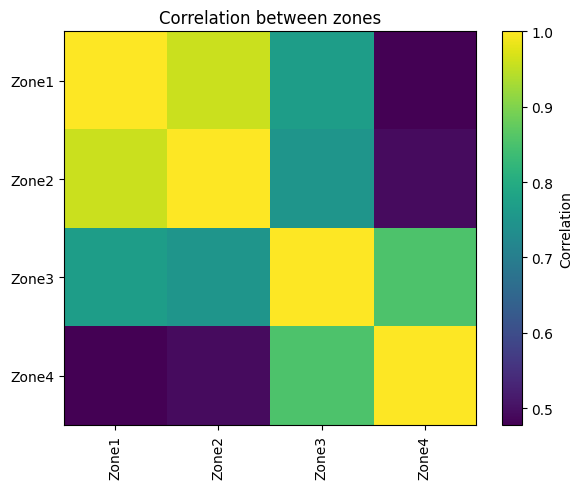

Zone,Zone1,Zone2,Zone3,Zone4
Zone,,,,
Zone1,1.000000,0.958468,0.768878,0.477518
Zone2,0.958468,1.000000,0.750190,0.493351
Zone3,0.768878,0.750190,1.000000,0.854056
Zone4,0.477518,0.493351,0.854056,1.000000


In [12]:
corr = wide.corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(label="Correlation")
plt.title("Correlation between zones")
plt.tight_layout()
plt.show()

corr


Based on the monitored temperature levels, temporal dynamics, and correlations between zones, we will now try to explicitly classify the monitored zones. Since no metadata describing the zones is available, this classification is based on observed behavior and should be interpreted as indicative rather than definitive.

- Although we did not observe any significat differences between zone 1 and zone 2 in the plots, we can observe one small difference in the tempaterure in month of August. Zone 1 has slightly higher temperature than zone 2. Knowing that office area has an ventilation system we can assume this is classfiied as zone 2, whether zone 1 is a living area. In the summer peak months, the ventilation system in the office area likely helps to moderate indoor temperatures, preventing them from rising as much as in the living area where such systems may not be present or as effective.

Zone 1 - Living Area and 
Zone 2 - Office Area

- Assuming very little access to the basement during the day, being underground, and keeping the temperature relatively stable, we can classify zone 3 as the basement .

Zone 3 - Basement 

- With the remaining zone 4, no ventilation system, and tempaterure patterns indicating high influence of use during the zyear with cold air inflow in winter and warm air in summer, we can classify it as the stairwell.

Zone 4 - Stairwell



### Part 2: SimulationData analysis

We next open the *SimulationData* database and inspect its contents using Numbers (version 14.4). It can be observed immediately that the data contains multiple columns representing simulated sensor values over time, with separate columns for each building zone. In addition, an extra column indicates the applied insulation variant, namely 10 cm or 30 cm insulation.

In this case, the simulation data is organized into two tables, each corresponding to one insulation variant. This structure allows a direct comparison of the simulated zone behavior under different insulation thicknesses.


In [13]:
sim = pd.read_excel("SimulationData.xlsx")
sim.columns = [c.strip() for c in sim.columns]

sim.head(), sim.shape, sim.columns


(   Hour        VariantID  Zone1  Calculated Value (Zone 1)  Zone2  \
 0     2  10cm Insulation  Zone1                  22.042716  Zone2   
 1     3  10cm Insulation  Zone1                  22.037426  Zone2   
 2     4  10cm Insulation  Zone1                  22.029980  Zone2   
 3     5  10cm Insulation  Zone1                  22.020053  Zone2   
 4     6  10cm Insulation  Zone1                  22.006532  Zone2   
 
    Calculated Value (Zone 2)  Zone3  Calculated Value (Zone 3)  Zone4  \
 0                  22.021330  Zone3                  21.987686  Zone4   
 1                  22.021594  Zone3                  21.918767  Zone4   
 2                  22.016355  Zone3                  21.803302  Zone4   
 3                  22.006803  Zone3                  21.655887  Zone4   
 4                  21.993660  Zone3                  21.488122  Zone4   
 
    Calculated Value (Zone 4)  
 0                  21.230625  
 1                  20.988309  
 2                  20.768183  
 3  

We check if there is no misslabeling in the insulation column.

In [14]:
sim["VariantID"].unique()


array(['10cm Insulation'], dtype=object)

To work with the zone data, we convert it to numeical floats and store in a array.

In [15]:
zone_cols = [c for c in sim.columns if "Calculated Value" in c]
zone_cols


['Calculated Value (Zone 1)',
 'Calculated Value (Zone 2)',
 'Calculated Value (Zone 3)',
 'Calculated Value (Zone 4)']

In [16]:
for c in zone_cols:
    sim[c] = (
        sim[c].astype(str)
              .str.replace(",", ".", regex=False)
              .astype(float)
    )

sim[zone_cols].describe()


,Calculated Value (Zone 1),Calculated Value (Zone 2),Calculated Value (Zone 3),Calculated Value (Zone 4)
count,8759.000000,8759.000000,8759.000000,8759.000000
mean,23.761289,21.935051,11.302048,18.778452
std,2.768826,0.942518,0.652021,3.897950
min,21.000000,21.000000,10.855754,10.131538
25%,21.000000,21.000000,10.958835,15.287067
50%,22.561588,21.375542,11.205842,20.183815
75%,26.620918,23.000000,11.533724,22.237101
max,28.610466,23.000000,21.987686,24.371066


But since above is only for a table with one insulation variant, we next check the sheet names to see both insulation variants.

In [17]:
xlsx = pd.ExcelFile("SimulationData.xlsx")
xlsx.sheet_names


['10cm Insulation', '30cm Insulation']

In [18]:
sim10 = pd.read_excel("SimulationData.xlsx", sheet_name="10cm Insulation")
sim30 = pd.read_excel("SimulationData.xlsx", sheet_name="30cm Insulation")


In [19]:
zone_cols = [c for c in sim10.columns if "Calculated Value" in c]

for c in zone_cols:
    sim10[c] = sim10[c].astype(str).str.replace(",", ".", regex=False).astype(float)
    sim30[c] = sim30[c].astype(str).str.replace(",", ".", regex=False).astype(float)


In [20]:
sim10.shape, sim30.shape

((8759, 10), (8759, 10))

Unlike the monitoring database, which uses explicit timestamps, the simulation data represents time using a discrete hour index. Each row corresponds to a simulated hour within a representative period.

The simulation results are therefore not tied to a specific calendar date, but instead describe the temporal evolution of zone temperatures within the simulation horizon. This differs from the monitoring data, which contains real-world timestamps, but still allows a consistent comparison between insulation variants, as long as identical hour indices are used.

To compare the effect of different insulation thicknesses, we will look at both simulation variants use the same hour definition. As long as temperatures for 10 cm and 30 cm insulation are evaluated at the same simulated hour, the difference reflects the additional thermal effect of increased insulation.


We check for missing values and matching hour indices between the two insulation variants:

In [21]:
sim10.isna().sum(), sim30.isna().sum()


(Hour                         0
 VariantID                    0
 Zone1                        0
 Calculated Value (Zone 1)    0
 Zone2                        0
 Calculated Value (Zone 2)    0
 Zone3                        0
 Calculated Value (Zone 3)    0
 Zone4                        0
 Calculated Value (Zone 4)    0
 dtype: int64,
 Hour                         0
 VariantID                    0
 Zone1                        0
 Calculated Value (Zone 1)    0
 Zone2                        0
 Calculated Value (Zone 2)    0
 Zone3                        0
 Calculated Value (Zone 3)    0
 Zone4                        0
 Calculated Value (Zone 4)    0
 dtype: int64)

In [22]:
print("10 cm hours:", sim10["Hour"].min(), "to", sim10["Hour"].max())
print("30 cm hours:", sim30["Hour"].min(), "to", sim30["Hour"].max())


10 cm hours: 2 to 8760
30 cm hours: 2 to 8760


To quantify the additional effect of increasing insulation thickness from 10 cm to 30 cm, both simulation datasets are aligned by the simulated hour index. Temperature differences are then computed for identical hours and zones.


In [23]:
sim10_h = sim10.set_index("Hour")[zone_cols].sort_index()
sim30_h = sim30.set_index("Hour")[zone_cols].sort_index()

common_hours = sim10_h.index.intersection(sim30_h.index)
sim10_h = sim10_h.loc[common_hours]
sim30_h = sim30_h.loc[common_hours]

delta = sim30_h - sim10_h


We now look at the statistics in the scenario when we increase the insulation from 10 cm to 30 cm.

In [24]:
delta.head()
delta.describe()


,Calculated Value (Zone 1),Calculated Value (Zone 2),Calculated Value (Zone 3),Calculated Value (Zone 4)
count,8759.000000,8759.000000,8.759000e+03,8759.000000
mean,2.139972,0.546218,1.708870e-01,0.391509
std,1.113788,0.736610,8.837561e-02,0.363487
min,0.000000,0.000000,9.947598e-14,-1.331679
25%,1.250422,0.000000,1.030294e-01,0.160920
50%,2.259731,0.030461,1.769529e-01,0.314197
75%,2.879112,1.060369,2.260321e-01,0.511441
max,4.398953,2.000000,3.599416e-01,1.779324


In [25]:
delta_summary = pd.DataFrame({
    "mean_delta_T": delta.mean(),
    "max_delta_T": delta.max(),
    "min_delta_T": delta.min(),
    "std_delta_T": delta.std()
}).sort_values("mean_delta_T", ascending=False)

delta_summary


,mean_delta_T,max_delta_T,min_delta_T,std_delta_T
Calculated Value (Zone 1),2.139972,4.398953,0.000000e+00,1.113788
Calculated Value (Zone 2),0.546218,2.000000,0.000000e+00,0.736610
Calculated Value (Zone 4),0.391509,1.779324,-1.331679e+00,0.363487
Calculated Value (Zone 3),0.170887,0.359942,9.947598e-14,0.088376


And present the results visually:

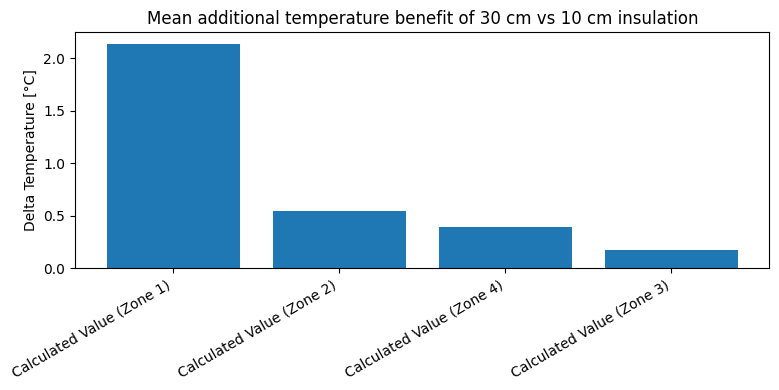

In [26]:
plt.figure(figsize=(8,4))
plt.bar(delta_summary.index, delta_summary["mean_delta_T"])
plt.title("Mean additional temperature benefit of 30 cm vs 10 cm insulation")
plt.ylabel("Delta Temperature [°C]")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


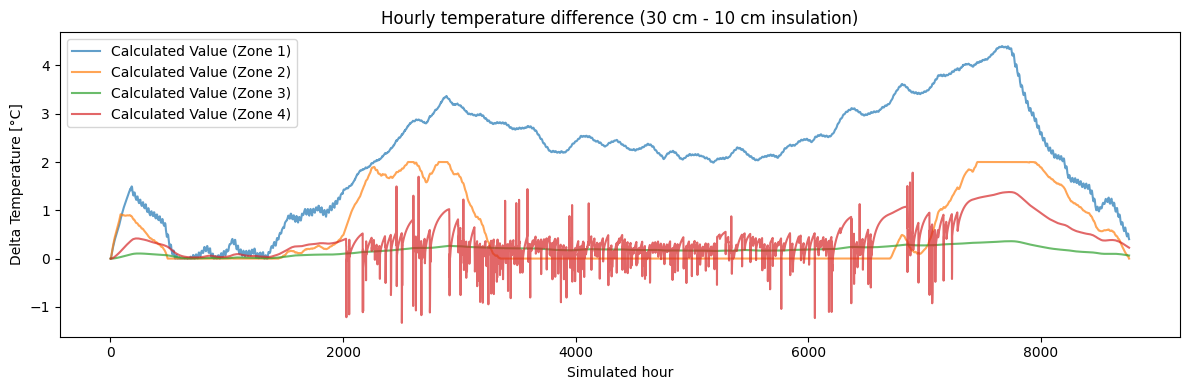

In [27]:
plt.figure(figsize=(12,4))
for col in delta.columns:
    plt.plot(delta.index, delta[col], label=col, alpha=0.7)

plt.title("Hourly temperature difference (30 cm - 10 cm insulation)")
plt.xlabel("Simulated hour")
plt.ylabel("Delta Temperature [°C]")
plt.legend()
plt.tight_layout()
plt.show()


The simulation results show that increasing the insulation thickness from 10 cm to 30 cm leads to a small but consistent increase in indoor temperatures across zones 1-3. The magnitude of the effect differs between zones, indicating that some areas of the building benefit more strongly from additional insulation.

It can be seen that Zone 1 (clssified as Living Area) shows by far the largest mean temperature increase (2°C) and hourly temperature difference, indicating a strong sensitivity to insulation thickness and suggesting that this zone benefits most from additional insulation. Zone 2(Office space that we know is ventilated) and Zone 4 (Stairwell) exhibit moderate average temperature increases ( 0.55 °C and 0.40 °C, respectively), while Zone 3 (Basement) shows only a very small mean increase but supprisingly also decreate in the temperature.

The limited and partially negative temperature response observed in the basement can be explained by its thermal coupling to the ground. Unlike above-ground zones, basement temperatures are influenced by the relatively stable soil temperature. Increasing insulation thickness may reduce not only heat losses but also beneficial heat exchange with the ground, resulting in a negligible or slightly negative net temperature delta. This highlights that insulation measures in underground zones require careful consideration and do not necessarily yield the same benefits as above-ground insulation.



| Zone | Interpreted building area | Justification |
|-----|---------------------------|---------------|
| Zone 1 | Living area | Highest temperatures and strongest insulation response |
| Zone 2 | Office area | Moderate temperatures, stable behavior due to ventilation |
| Zone 3 | Basement | Low sensitivity to insulation, ground effects |
| Zone 4 | Stairwell | Intermediate temperatures and moderate insulation response |


Since the monitoring database contains only a single measured variable per zone, correlations between different physical parameters (temperature vs humidity) cannot be evaluated.

## Conclusion

- The living area (Zone 1) shows the strongest thermal response and the highest benefit from 30 cm insulation. Therefore, increased insulation thickness is strongly recommended for this zone.

- Increased insulation thickness is also recommended for the office area (Zone 2). As this zone is ventilated (though the ventilation system is not specified it could potentially be mechanical system), improved insulation can help reduce heat losses associated with ventilation and may lead to long-term energy savings.

- Insulation measures in the basement (Zone 3) should be carefully considered. The simulation results indicate limited and partly inconsistent temperature benefits, which can be explained by the thermal coupling between the basement and the surrounding ground.

- To reduce uncertainty and improve future analyses, additional measurements such as relative humidity are recommended. These parameters would allow a more comprehensive assessment of indoor comfort, moisture-related risks, and energy efficiency.
